# Lumo Run - Deep FFCN and CNN

#### Load dependencies

In [3]:
print('made it here 1') # these are used for Sherlock to check what is causing the hiccup

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization 
from keras import regularizers 
from keras import optimizers

print('made it here 2')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print('made it here 3')

import tensorflow as tf

from datetime import datetime
from dateutil import tz
from IPython import embed
import time
from time import strftime, gmtime
import socket
import pickle
import os.path
#import dill #can't find dill

print('made it here 4')

from pathlib import Path
from sklearn.metrics import confusion_matrix 

np.random.seed(7) # Set seed for reproducibility

made it here 1


C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


made it here 2
made it here 3
made it here 4


#### Set Hyperparameters

In [78]:
# Data Setup

num_channels = 7 # number of time-series channels of data (i.e. 7 kinematic features) #NOTE: Change to 6 by removing Pelvic Tilt (recommended by Lumo)
num_anthropometrics = 4 # number of user anthropometric data elements
input_window_size = 36 # number of timestamps used in the input for prediction (i.e. the input window)
label_window_size = 30 # number of timestamps used to label the speed we will be predicting
speed_bucket_size = '0.1' # how to round the data for classification task. Consider '0.5', '0.1', and 'none_use_regression'

previous_model_weights_to_load = "" # If non-empty, load weights from a previous model (note: architectures must be identical)
model_architecture = 'CNN' # 'FCN', 'CNN'
data_input_table_structure = 'Raw_Timeseries' # 'Vectorized_By_Row' 'Raw_Timeseries'
myFileDirectory = 'C:/Users/adam/Documents/CS 230/Project/Lumo Data/'
myFileName = 'TimeSeries_InputVector_100runs'
myFileLocation = myFileDirectory + myFileName + '.csv'
        # Other data files/folders to potentially use:
        # '../datasets/'  |  'C:/Users/adam/Documents/CS 230/Project/Lumo Data/
        # 'quarter-big'   |   'TimeSeries_InputVector_100runs'   |   'TimeSeries_InputVector_15runs'
        # 'SAMPLE_TimeSeries_Longest1000Runs_wAnthro_MultiLabeledSpeed_20180523'
        
# Fully Connected Architecture

num_hidden_units_fc_layers = [256, 256, 256, 128, 128, 128]
hidden_units_strategy = ''.join(str(num) + "_" for num in num_hidden_units_fc_layers) # document strategy 
num_hidden_fc_layers = len(num_hidden_units_fc_layers) # document strategy
activations_fc_layers = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
activations_strategy = ''.join(str(num) + "_" for num in activations_fc_layers) # document strategy
dropout_rate_fc_layers = [1.0, 1.0, 1.0, 0.8, 0.8, 0.8]
dropout_rates = ''.join(str(num) + "_" for num in dropout_rate_fc_layers) # document strategy

# Convolutional Architecture
    
sample_stride = 18 # how many timestamps to shift over between each unique training example
num_filters = 40 # number of filters in Conv2D layer (aka depth) # we used 40, ex; used 128
kernel_size = 3 # kernal size of the Conv2D layer # we use 6, example used 2, I would guess closer to 3
activation_conv_layer = "relu" # options are "relu" , "tanh" and "sigmoid" - used for depthwise_conv
max_pool_kernel_size = 3 # max pooling window size# we use 6, example used 2, I don't agre with 6
conv_layer_dropout = 0.2 # dropout ratio for dropout layer # we don't use in our model

num_hidden_units_fc_layers_CNN = [50]
hidden_units_strategy_CNN = ''.join(str(num) + "_" for num in num_hidden_units_fc_layers_CNN) # document strategy 
num_hidden_fc_layers_CNN = len(num_hidden_units_fc_layers_CNN) # document strategy
activations_fc_layers_CNN = ['tanh']
activations_strategy_CNN = ''.join(str(num) + "_" for num in activations_fc_layers_CNN) # document strategy
dropout_rate_fc_layers_CNN = "" # [1.0]
dropout_rates_CNN = ''.join(str(num) + "_" for num in dropout_rate_fc_layers_CNN) # document strategy

num_hidden_units_fc_layers_CNN[0] 
activations_fc_layers_CNN[0]
    
# Training strategy

batch_size = 50 # we used 50 for CNN, 128 for FCN
learning_rate = 0.0001 # we used 0.001 for FCN, 0.0001 for CNN
training_epochs = 50
optimizer_type = 'gradient' # options are: "adam" , "rmsprop", "gradient" # adam for FCN, gradient for CNN
loss_function = 'categorical_crossentropy' # Other options (from keras defaults or custom) include: 'categorical_crossentropy' ,'mse', 'mae', 'class_mse', 'class_mae'

#### Set Up Automatic Reporting and Plotting

In [79]:
# Choose the 3 most interesting evaluation metrics to report on in final plots

accuracy_reporting_metric_1 = 'class_mae' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_1 = 'val_' + accuracy_reporting_metric_1
accuracy_reporting_metric_2 = 'class_percent_2buckRange' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_2 = 'val_' + accuracy_reporting_metric_2
accuracy_reporting_metric_3 = 'class_mse' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_3 = 'val_' + accuracy_reporting_metric_3

plt.style.use('ggplot') # style of matlab plots to produce

In [80]:
# File naming conventions

file_name = strftime("%Y%m%d_%H%M%S", gmtime()) # user input for filename of saved model
plot_note = ""
model_to_lod = ""
results_file_name = "Default_Model_Results_Table_20180726" + "_" + model_architecture

customize_file_names = False
if customize_file_names:
    file_name = input("String to add to model filename (defaults to time stamp if nothing entered):")  
    results_file_name = input("Name of the results file, a table, to store the prediction results") # name of results file
    plot_note = input("Note you'd like to add in the legend of the primary learning curves plot:") #user input to add note to plot
    model_to_load = input("Enter the model name to load to initialize parameters - leave blank to start fresh") #user input to load prev model

#### Define functions for data processing and plotting

In [81]:
def read_data(file_path):
    data = pd.read_csv(file_path,header = 0) # This uses the header row (row 0) as the column names
    return data

def windows(data, size): # define time windows to create each training example
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += sample_stride # other common options: (size / 2)
    
# Used for vectorized input WITH SQL pre-processing
def segment_signal_FCN_vector(data_inputs, data_full): 
    dataframe_input = data_inputs.loc[:, 'gender':'pelvic_tilt_lag_0'] # select all columns from gender to pelvic_tilt_lag_0
    dataframe_labels = data_full.loc[:, 'gps_speed_lag_7':'gps_speed_lag_3'] # select all columns from gender to pelvic_tilt_lag_0
    segments = dataframe_input.values
    labels_before_avg = dataframe_labels.values
    if speed_bucket_size == '0.1':
        labels = np.around(np.mean(labels_before_avg, axis=1),decimals=1)
    elif speed_bucket_size == '0.5':
        labels = np.around(2*np.mean(labels_before_avg, axis=1),decimals=0)/2
    elif speed_bucket_size == 'none_use_regression':
        labels = np.mean(labels_before_avg, axis=1)
    return segments, labels

# Used for vectorized input WITHOUT SQL pre-processing
def segment_signal(data_inputs, data_full, input_window_size = input_window_size):
    if  model_architecture == 'FCN':
        segments = np.empty((0,input_window_size*num_channels + num_anthropometrics))
    elif model_architecture == 'CNN':
        segments = np.empty((0, input_window_size, num_channels + num_anthropometrics))
    labels = np.empty((0))
    for (start, end) in windows(data_full['timestamp'], input_window_size):
        a = data_inputs["bounce"][start:end]
        b = data_inputs["braking"][start:end]
        c = data_inputs["cadence"][start:end]
        d = data_inputs["ground_contact"][start:end]
        e = data_inputs["pelvic_drop"][start:end]
        f = data_inputs["pelvic_rotation"][start:end]
        g = data_inputs["pelvic_tilt"][start:end]
        if model_architecture == 'FCN':
            aa = data_inputs["age"][start]
            bb = data_inputs["weight"][start]
            cc = data_inputs["height"][start]
            dd = data_inputs["gender"][start] 
        elif model_architecture == 'CNN':
            aa = data_inputs["age"][start:end]
            bb = data_inputs["weight"][start:end]
            cc = data_inputs["height"][start:end]
            dd = data_inputs["gender"][start:end]         
        if(end < data_full.shape[0] and len(data_full['timestamp'][start:end]) == input_window_size and data_full['activity_id'][start]==data_full['activity_id'][end]):
            if model_architecture == 'FCN':
                segments_toadd = np.vstack([np.dstack([a,b,c,d,e,f,g])])
                segments_toadd_reshape = segments_toadd.reshape(input_window_size * num_channels)
                segments = np.vstack([segments,np.hstack([aa,bb,cc,dd,segments_toadd_reshape])])
            elif model_architecture == 'CNN':
                segments = np.vstack([segments,np.dstack([aa,bb,cc,dd,a,b,c,d,e,f,g])])
            start_labeling = np.int(np.floor(start+(end-start)/2) - np.floor(label_window_size/2))
            end_labeling = start_labeling + label_window_size
            if speed_bucket_size == '0.1':
                labels = np.append(labels,np.around(np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=1)) # round to nearest decimal
            elif speed_bucket_size == '0.5':
                labels = np.append(labels,np.around(2*np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=0)/2) # round to nearest half unit
            elif speed_bucket_size == 'none_use_regression':
                labels = np.append(labels,np.mean(data_full["gps_speed_true"][start_labeling:end_labeling])) # no rounding, use regression
    return segments, labels

# Used for vectorized input WITHOUT SQL pre-processing
def segment_signal_label_only(data_inputs, data_full, input_window_size = input_window_size):
    labels = np.empty((0))
    for (start, end) in windows(data_full['timestamp'], input_window_size):        
        if(end < data_full.shape[0] and len(data_full['timestamp'][start:end]) == input_window_size and data_full['activity_id'][start]==data_full['activity_id'][end]):
            start_labeling = np.int(np.floor(start+(end-start)/2) - np.floor(label_window_size/2))
            end_labeling = start_labeling + label_window_size
            if speed_bucket_size == '0.1':
                labels = np.append(labels,np.around(np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=1)) # round to nearest decimal
            elif speed_bucket_size == '0.5':
                labels = np.append(labels,np.around(2*np.mean(data_full["gps_speed_true"][start_labeling:end_labeling]),decimals=0)/2) # round to nearest half unit
            elif speed_bucket_size == 'none_use_regression':
                labels = np.append(labels,np.mean(data_full["gps_speed_true"][start_labeling:end_labeling])) # no rounding, use regression
    return labels

def load_results_file_FCN(results_file_name):
    my_file = Path("../Model Performance Tables/" + results_file_name + ".csv")
    if my_file.is_file():
        print("Found results file")
        prev_results=pd.read_csv(my_file,header=0)
        print(list(prev_results.columns.values))
        return prev_results
    else:
        print("no results file found - creating file")
        a=[[model_architecture,
            file_name,
            "na",
            myFileLocation,
            training_epochs,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            batch_size,
            learning_rate,
            speed_bucket_size,
            loss_function,
            input_window_size,
            label_window_size,
            optimizer_type,
            "",
            "",
            "",
            num_hidden_fc_layers,
            hidden_units_strategy,
            activations_strategy,
            dropout_rates
            ]]
        
        df=pd.DataFrame(a, columns=["model type",
                                    "model filename",
                                    "plot filename",
                                    "data filename",
                                    "epochs",
                                    "runtime",
                                    "dev accuracy 1",
                                    "train accuracy 1",
                                    "dev accuracy 2",
                                    "train accuracy 2",
                                    "dev accuracy 3",
                                    "train accuracy 4",
                                    "batch_size",
                                    "learning_rate",
                                    "speed_bucket_size",
                                    "loss_function",
                                    "input_window_size",
                                    "label_window_size",
                                    "optimizer_type",
                                    "evaluation_metric_1",
                                    "evaluation_metric_2",
                                    "evaluation_metric_3",
                                    "num_hidden_fc_layers",
                                    "hidden_units_strategy",
                                    "activations_strategy",
                                    "dropout_rates"])
        
        df.to_csv("../Model Performance Tables/" + results_file_name + ".csv",index=False ) 
        return df

def load_results_file_CNN(results_file_name):
    my_file = Path("../Model Performance Tables/" + results_file_name + ".csv")
    if my_file.is_file():
        print("Found results file")
        prev_results=pd.read_csv(my_file,header=0)
        print(list(prev_results.columns.values))
        return prev_results
    else:
        print("no results file found - creating file")
        a=[[model_architecture,
            file_name,
            "na",
            myFileLocation,
            training_epochs,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            batch_size,
            learning_rate,
            speed_bucket_size,
            loss_function,
            input_window_size,
            label_window_size,
            optimizer_type,
            "",
            "",
            "",
            hidden_units_strategy_CNN,
            num_filters,
            kernel_size,
            sample_stride,
            activation_conv_layer,
            activations_strategy_CNN,
            max_pool_kernel_size
            ]]
        
        df=pd.DataFrame(a, columns=["model type",
                                    "model filename",
                                    "plot filename",
                                    "data filename",
                                    "epochs",
                                    "runtime",
                                    "dev accuracy 1",
                                    "train accuracy 1",
                                    "dev accuracy 2",
                                    "train accuracy 2",
                                    "dev accuracy 3",
                                    "train accuracy 2",
                                    "batch_size",
#                                     "num_hidden_fc_layers",
#                                     "activations_strategy",
#                                     "dropout_rates",
                                    "learning_rate",
                                    "speed_bucket_size",
                                    "loss_function",
                                    "input_window_size",
                                    "label_window_size",
                                    "optimizer_type",
                                    "evaluation_metric_1",
                                    "evaluation_metric_2",
                                    "evaluation_metric_3",
                                    "hidden_units_strategy_CNN",
                                    "num_filters",
                                    "kernel_size",
                                    "sample_stride",
                                    "activation_conv_layer",
                                    "activations_strategy_CNN",
                                    "max_pool_kernel_size"])
        
        df.to_csv("../Model Performance Tables/" + results_file_name + ".csv",index=False ) 
        return df        

#### Normalize Data

In [82]:
dataset = read_data(myFileLocation)

if data_input_table_structure == 'Raw_Timeseries':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_tilt'] # normalize all columns from gender to pelvic_tilt
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()
elif data_input_table_structure == 'Vectorized_By_Row':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_tilt_lag_0'] # normalize all columns from gender to pelvic_tilt_lag_0
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()

KeyError: 'pelvic_tilt'

#### Preprocess data to input into model

In [ ]:
np_array_file_string_segment = "../Saved NP Arrays/" + str(myFileName) + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment.npy"
np_array_file_string_label = "../Saved NP Arrays/" + str(myFileName) + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_label.npy"
np_array_file_string_label2num = "../Saved NP Arrays/" + str(myFileName) + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_label2num.npy"

if os.path.isfile(np_array_file_string_segment):   # if this file already exists, load the relevant saved np arrays
    segments = np.load(np_array_file_string_segment, allow_pickle=True)
    labels = np.load(np_array_file_string_label, allow_pickle=True)
    labels_to_number = np.load(np_array_file_string_label2num, allow_pickle=True)
else:    # if this file does not exist, run segment_signal method and create np arrays for future use
    if data_input_table_structure == 'Raw_Timeseries':
        segments, labels = segment_signal(dataset_inputs_normalized, dataset)
    elif data_input_table_structure == 'Vectorized_By_Row':
        segments, labels = segment_signal_FCN_vector(dataset_inputs_normalized, dataset)
    if speed_bucket_size != 'none_use_regression': # if not using regression, convert to one-hot vector labels
         labels_to_number = np.unique(labels) # Caches "labels_to_number" in order to use in rmse calculation for classification
         labels = np.asarray(pd.get_dummies(labels), dtype = np.int8) # one-hot labels to classify nearest bucket
    np.save(np_array_file_string_segment, segments, allow_pickle=True)
    np.save(np_array_file_string_label, labels, allow_pickle=True)
    np.save(np_array_file_string_label2num, labels_to_number, allow_pickle=True)

num_buckets_total = len(labels[1]) # total number of classification buckets that exist in the dataset (here, classification bucket == classification class)

In [ ]:
# Debugger Helper Code

print(labels_to_number)
print(labels.shape)
print(segments.shape)
print(labels[0:2])

#### Shuffle data into training and dev

In [ ]:
train_dev_split = np.random.rand(len(segments)) < 0.90
if data_input_table_structure == 'Raw_Timeseries':
    reshapedSegments = segments.reshape(segments.shape[0], input_window_size, num_channels+num_anthropometrics, 1)
    X_train = reshapedSegments[train_dev_split]
    X_test = reshapedSegments[~train_dev_split]
elif data_input_table_structure == 'Vectorized_By_Row':
    X_train = segments[train_dev_split]
    X_test = segments[~train_dev_split]
y_train = labels[train_dev_split]
y_test = labels[~train_dev_split]

In [ ]:
print(train_dev_split.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#### Implement NN architecture in a Keras model

In [ ]:
def fcnModel():
    model = Sequential()
    # First layer
    model.add(Dense(num_hidden_units_fc_layers[0], activation=activations_fc_layers[0], input_shape=(input_window_size*num_channels + num_anthropometrics,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_fc_layers[0]))
    # Intermediate layers
    for L in range(1, num_hidden_fc_layers):
        model.add(Dense(num_hidden_units_fc_layers[L], activation=activations_fc_layers[L]))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_fc_layers[L]))
    # Last hidden layer
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        model.add(Dense(num_buckets_total, activation='softmax'))
    else:                                          # if regression, use linear for last layer
        model.add(Dense(1,activation='linear'))
    return model
        
def cnnModel():
    model = Sequential()
    model.add(Conv2D(num_filters, (kernel_size,1),input_shape=(input_window_size, num_channels+num_anthropometrics,1),activation=activation_conv_layer))
    model.add(MaxPooling2D(pool_size=(max_pool_kernel_size,1),padding='valid',strides=(2,1)))
    model.add(Conv2D(num_filters//10, (kernel_size,1),activation=activation_conv_layer)) # add additional CNN layer
    # model.add(Dropout(dropOutRatio)) # not used in our model # adding a dropout layer for the regularization
    model.add(Flatten()) # flatten the output in order to apply the fully connected layer
    model.add(Dense(num_hidden_units_fc_layers_CNN[0], activation=activations_fc_layers_CNN[0])) # add first fully connected layer
    # model.add(BatchNormalization())
    # model.add(Dropout(dropout_rate_fc_layers_CNN[0]))
    # Intermediate fully connected layerslayers
    for L in range(1, num_hidden_fc_layers_CNN):
        model.add(Dense(num_hidden_units_fc_layers_CNN[L], activation=activations_fc_layers_CNN[L]))
        # model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_fc_layers_CNN[L]))
    # Last hidden layer
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        model.add(Dense(num_buckets_total, activation='softmax'))
    else:                                          # if regression, use linear for last layer
        model.add(Dense(1,activation='linear'))
    return model

In [83]:
if  model_architecture == 'FCN':
    model = fcnModel()
elif model_architecture == 'CNN':
    model = cnnModel()

In [84]:
# View model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 34, 11, 40)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 11, 40)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 11, 4)         484       
_________________________________________________________________
flatten_5 (Flatten)          (None, 616)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                30850     
_________________________________________________________________
dense_10 (Dense)             (None, 43)                2193      
Total params: 33,687
Trainable params: 33,687
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Debuging helper code

print(segments[0,1:10])
print(labels.shape)
print(segments.shape)

[[-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.26079322  0.25859799
  -0.28979339  0.07761158 -1.50060547  0.23374441 -0.9314233 ]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.09654003  0.25859799
  -0.46401954  0.07761158 -1.50060547  0.13925945 -0.91367963]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.09654003  0.17278589
  -0.72535877  0.45929608 -1.42896929  0.19595042 -0.94916698]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.1877918   0.1012758
  -0.58017031  0.40146509 -1.33942408  0.22744541 -0.94916698]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.26079322  0.08697378
  -0.6382457   0.32050171 -1.21406077 -0.37095933 -1.0911164 ]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.24710546  0.32295707
  -0.15912377 -0.07853208 -1.08869746 -0.60717173 -0.99352617]
 [-0.12615162 -1.10420215 -0.58244325 -1.33529223 -0.20604216  0.51603431
  -0.02845416 -0.13057997 -0.82006181 -0.57882624 -0.96691066]
 [-0.12615162 -1.10420215 -0.58244325 -1.3

#### Define custom loss functions and evaluation metrics

In [86]:
from keras import backend as K

def class_mse(y_true, y_pred):
    return K.mean(K.square(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)
    # Note: we cannot define RMSE directly in Keras since the loss function is defined for one training example at a time

def class_mae(y_true, y_pred):
    return K.mean(K.abs(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)

def class_mape(y_true, y_pred):
    diff = K.abs((K.sum(y_true * labels_to_number,axis=-1,keepdims=True) - K.sum(y_pred * labels_to_number,axis=-1,keepdims=True)) / K.clip(K.abs(K.sum(y_true * labels_to_number,axis=-1,keepdims=True)),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

def class_percent_1buckLow(y_true, y_pred): # percent of times the prediction is 1 bucket below the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx())

def class_percent_2buckLow(y_true, y_pred): # percent of times the prediction is 2 buckets below the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())
    
def class_percent_1buckHigh(y_true, y_pred): # percent of times the prediction is 1 bucket above the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx())    

def class_percent_2buckHigh(y_true, y_pred): # percent of times the prediction is 2 buckets above the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx())    

def class_percent_1buckRange(y_true, y_pred): # percent of times the prediction is within 1 bucket of true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

def class_percent_2buckRange(y_true, y_pred): # percent of times the prediction is within 2 buckets of true value
    return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())    

# For reference, from keras documentation: https://github.com/keras-team/keras/blob/master/keras/losses.py
#def class_categorical_accuracy(y_true, y_pred):
    #return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

#### Configure model loss and optimization function

In [87]:
# Define Optimizer
if optimizer_type == 'adam':
    model_optimizer = optimizers.Adam(lr = learning_rate) #, decay, beta_1, beta_2 are HPs
elif optimizer_type == 'rmsprop':
    model_optimizer = optimizers.RMSprop(lr = learning_rate) #, decay, rho
elif optimizer_type == 'gradient':
    model_optimizer = optimizers.SGD(lr = learning_rate) #, decay, momentum

# Compile model with appropriate loss function
if speed_bucket_size != 'none_use_regression': # if performing classification, ALWAYS use cross-entropy loss
    model.compile(loss ='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy',class_percent_1buckRange,class_percent_2buckRange, class_mae, class_mse]) # class_percent_1buckLow,class_percent_1buckHigh,class_percent_2buckLow, class_percent_2buckHigh,'class_mape'
else:                                          # if performing regression, use mean squared error or mean absolute error
    if loss_function == 'categorical_crossentropy': raise NameError('Are you sure you want to use cross entropy loss with a regression tasks!?')
    model.compile(loss = loss_function, optimizer=model_optimizer, metrics=['mse','mae']) # options: 'mse','mae', 'mape'

In [88]:
# debugger code

#model.compile(loss ='categorical_crossentropy', optimizer='adam', metrics=['accuracy',class_percent_1buckRange,class_percent_2buckRange, class_mae, class_mse]) # class_percent_1buckLow,class_percent_1buckHigh,class_percent_2buckLow, class_percent_2buckHigh,'class_mape'


#### Train!

In [89]:
# If desired, load weights from a previous model to start with model

if previous_model_weights_to_load != "":
    model.load_weights("../Model Final Parameters/" + previous_model_weights_to_load)

In [90]:
start_time = time.time()

history = model.fit(X_train, y_train, batch_size= batch_size, epochs=training_epochs, verbose=1, validation_data=(X_test, y_test))

end_time=time.time()

Train on 12229 samples, validate on 1369 samples
Epoch 1/50
12229/12229 [==============================] - 10s 823us/step - loss: 3.7471 - acc: 0.0108 - class_percent_1buckRange: 0.0197 - class_percent_2buckRange: 0.0275 - class_mae: 0.7267 - class_mse: 0.7036 - val_loss: 3.7390 - val_acc: 0.0095 - val_class_percent_1buckRange: 0.0256 - val_class_percent_2buckRange: 0.0380 - val_class_mae: 0.7359 - val_class_mse: 0.7212
Epoch 2/50
12229/12229 [==============================] - 10s 796us/step - loss: 3.7317 - acc: 0.0140 - class_percent_1buckRange: 0.0290 - class_percent_2buckRange: 0.0414 - class_mae: 0.7207 - class_mse: 0.6953 - val_loss: 3.7237 - val_acc: 0.0153 - val_class_percent_1buckRange: 0.0373 - val_class_percent_2buckRange: 0.0548 - val_class_mae: 0.7302 - val_class_mse: 0.7134
Epoch 3/50
12229/12229 [==============================] - 9s 745us/step - loss: 3.7169 - acc: 0.0190 - class_percent_1buckRange: 0.0446 - class_percent_2buckRange: 0.0648 - class_mae: 0.7155 - class_ms

KeyboardInterrupt: 

### Plot and save results

#### Save a plot of results

In [66]:
# Transform key results into a np arrary
trainAccuracy_1 = np.squeeze(history.history[accuracy_reporting_metric_1])
devAccuracy_1 = np.squeeze(history.history[dev_reporting_metric_1])
trainAccuracy_2 = np.squeeze(history.history[accuracy_reporting_metric_2])
devAccuracy_2 = np.squeeze(history.history[dev_reporting_metric_2])    
trainAccuracy_3 = np.squeeze(history.history[accuracy_reporting_metric_3])
devAccuracy_3 = np.squeeze(history.history[dev_reporting_metric_3])
trainAccuracy_4 = np.squeeze(history.history['acc'])
devAccuracy_4 = np.squeeze(history.history['val_acc'])
epochs = np.squeeze(range(1,training_epochs + 1))

# Save results to a .csv in the "Learning Curve Results"
df_devAccuracy = pd.DataFrame(np.transpose(np.vstack([epochs,devAccuracy_1, devAccuracy_2, devAccuracy_3, devAccuracy_4])))
filepath_acc = "../Learning Curves/" + str(file_name) +"_AccuracyPerEpoch_Data" + ".csv"
df_devAccuracy.to_csv(filepath_acc, header = ["Epochs", dev_reporting_metric_1, dev_reporting_metric_2, dev_reporting_metric_3, 'acc'], index=False)

# Declare final values for results
final_accuracy_1 = history.history[accuracy_reporting_metric_1][training_epochs - 1]
final_accuracy_dev_1 = history.history[dev_reporting_metric_1][training_epochs - 1]
final_accuracy_2 = history.history[accuracy_reporting_metric_2][training_epochs - 1]
final_accuracy_dev_2 = history.history[dev_reporting_metric_2][training_epochs - 1]
final_accuracy_3 = history.history[accuracy_reporting_metric_3][training_epochs - 1]
final_accuracy_dev_3 = history.history[dev_reporting_metric_3][training_epochs - 1]
final_accuracy_4 = history.history['acc'][training_epochs - 1]
final_accuracy_dev_4 = history.history['val_acc'][training_epochs - 1]


C:\Users\adam\Anaconda3\lib\site-packages\matplotlib\legend.py:638: UserWarning: Unrecognized location "bestoutside". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


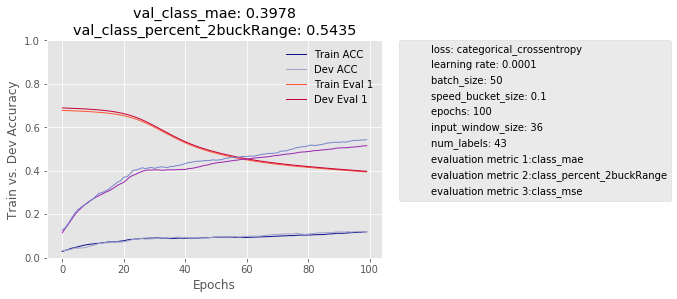

In [67]:
from matplotlib.patches import Rectangle
from matplotlib.legend import Legend

fig, ax1 = plt.subplots()
lines=[]

lines += ax1.plot(trainAccuracy_4,'#0e128c', label='Train Accuracy 2', linewidth=1) #'#DAF7A6'
lines += ax1.plot(devAccuracy_4,'#a3a4cc', label='Dev Accuracy 2', linewidth=1)# '#33FF00',
lines += ax1.plot(trainAccuracy_1,'#FF5733', label='Train Accuracy 1', linewidth=1)
lines += ax1.plot(devAccuracy_1,'#C70039', label='Dev Accuracy 1', linewidth=1)
lines += ax1.plot(trainAccuracy_2,'#9C27B0', label='Train Accuracy 2', linewidth=1)
lines += ax1.plot(devAccuracy_2,'#7986CB', label='Dev Accuracy 2', linewidth=1)
plt.ylim([0.0, 1.0])  # Surpress this for non-classification tasks

plt.ylabel('Train vs. Dev Accuracy')

plt.xlabel('Epochs')
plt.title(dev_reporting_metric_1 + ": " + str(np.around(final_accuracy_dev_1,4)) + "\n" + \
         dev_reporting_metric_2 + ": " + str(np.around(final_accuracy_dev_2,4))) 
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend([extra,extra,extra,extra,extra,extra,extra,extra,extra,extra],(
                                                "loss: " + loss_function,
                                                "learning rate: " + str(learning_rate),
                                                "batch_size: " + str(batch_size),
                                                "speed_bucket_size: " + speed_bucket_size,
                                                "epochs: "+str(training_epochs),
                                                "input_window_size: " + str(input_window_size),
                                                "num_labels: " + str(len(labels_to_number)),
                                                "evaluation metric 1:"+accuracy_reporting_metric_1,
                                                "evaluation metric 2:"+accuracy_reporting_metric_2,
                                                "evaluation metric 3:"+accuracy_reporting_metric_3,
                                                "note:" + plot_note),
                                                bbox_to_anchor=(1.05, 1),
                                                loc=2,
                                                borderaxespad=0.)

leg = Legend(ax1, lines[0:], ['Train ACC', 'Dev ACC','Train Eval 1','Dev Eval 1'],
             loc='bestoutside', frameon=False)
ax1.add_artist(leg);
plt.savefig("../Learning Curves/" + str(file_name) + "_AccuracyPerEpoch_Image.png", bbox_inches = "tight")
plt.show()

#### Record results of a model in a table:

In [68]:
# Add the results of the most recent run to the results file for documentation

if  model_architecture == 'FCN':
    a=[[model_architecture,
        file_name,
        "na",
        myFileLocation,
        training_epochs,  
        end_time - start_time,
        final_accuracy_1,
        final_accuracy_dev_1,
        final_accuracy_2,
        final_accuracy_dev_2,
        final_accuracy_3,
        final_accuracy_dev_3,
        batch_size,    
        learning_rate,
        speed_bucket_size,
        loss_function,
        input_window_size,
        label_window_size,
        optimizer_type,
        accuracy_reporting_metric_1,
        accuracy_reporting_metric_2,
        accuracy_reporting_metric_3,
        num_hidden_fc_layers,
        hidden_units_strategy,
        activations_strategy,
        dropout_rates
       ]]
    df=pd.DataFrame(a, columns=["model type",
                                "model filename",
                                "plot filename",
                                "data filename",
                                "epochs",
                                "runtime",
                                "train accuracy 1",
                                "dev accuracy 1",
                                "train accuracy 2",
                                "dev accuracy 2",
                                "train accuracy 3",
                                "dev accuracy 3",
                                "batch_size",  
                                "learning_rate",
                                "speed_bucket_size",
                                "loss_function",
                                "input_window_size",
                                "label_window_size",
                                "optimizer_type",
                                "evaluation_metric_1",
                                "evaluation_metric_2",
                                "evaluation_metric_3",
                                "num_hidden_fc_layers",
                                "hidden_units_strategy",
                                "activations_strategy",
                                "dropout_rates"])
    past_results = load_results_file_FCN(results_file_name)
elif model_architecture == 'CNN':     
    a=[[model_architecture,
        file_name,
        "na",
        myFileLocation,
        training_epochs,
        end_time - start_time,
        final_accuracy_1,
        final_accuracy_dev_1,
        final_accuracy_2,
        final_accuracy_dev_2,
        final_accuracy_3,
        final_accuracy_dev_3,
        batch_size,
        learning_rate,
        speed_bucket_size,
        loss_function,
        input_window_size,
        label_window_size,
        optimizer_type,
        accuracy_reporting_metric_1,
        accuracy_reporting_metric_2,
        accuracy_reporting_metric_3,
        hidden_units_strategy_CNN,
        num_filters,
        kernel_size,
        sample_stride,
        activation_conv_layer,
        activations_strategy_CNN,
        max_pool_kernel_size]]
    df=pd.DataFrame(a, columns=["model type",
                                "model filename",
                                "plot filename",
                                "data filename",
                                "epochs",
                                "runtime",
                                "dev accuracy 1",
                                "train accuracy 1",
                                "dev accuracy 2",
                                "train accuracy 2",
                                "dev accuracy 3",
                                "train accuracy 3",
                                "batch_size",
                                "learning_rate",
                                "speed_bucket_size",
                                "loss_function",
                                "input_window_size",
                                "label_window_size",
                                "optimizer_type",
                                "evaluation_metric_1",
                                "evaluation_metric_2",
                                "evaluation_metric_3",
                                "hidden_units_strategy_CNN",
                                "num_filters",
                                "kernel_size",
                                "sample_stride",
                                "activation_conv_layer",
                                "activations_strategy_CNN",
                                "max_pool_kernel_size"])    
    past_results = load_results_file_CNN(results_file_name)
past_results=pd.concat([past_results,df])
print(past_results)
past_results.to_csv("../Model Performance Tables/" + results_file_name + ".csv",index=False ) # Consider fixing to put the columns in not-alphabetical order

Found results file
['activation_conv_layer', 'activations_strategy_CNN', 'batch_size', 'data filename', 'dev accuracy 1', 'dev accuracy 2', 'dev accuracy 3', 'epochs', 'evaluation_metric_1', 'evaluation_metric_2', 'evaluation_metric_3', 'hidden_units_strategy_CNN', 'input_window_size', 'kernel_size', 'label_window_size', 'learning_rate', 'loss_function', 'max_pool_kernel_size', 'model filename', 'model type', 'num_filters', 'optimizer_type', 'plot filename', 'runtime', 'sample_stride', 'speed_bucket_size', 'train accuracy 1', 'train accuracy 2', 'train accuracy 2.1', 'train accuracy 3']
  activation_conv_layer activations_strategy_CNN  batch_size  \
0                  relu                    tanh_         128   
1                  relu                    tanh_         128   
2                  relu                    tanh_         128   
3                  relu                    tanh_         128   
4                  relu                    tanh_         128   
5                  rel

#### Build Confusion Matrix and Regression Plot

In [69]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

y_true = y_test
y_true_argmax = np.argmax(y_true, axis=1)

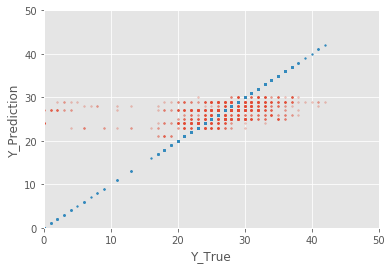

In [70]:
# Plot results
plt.scatter(y_true_argmax, y_pred_argmax, s=3, alpha=0.3)
plt.scatter(y_true_argmax, y_true_argmax, s=3, alpha=1)
#plt.scatter(y_true, y_pred, s=3, alpha=0.3) # For regression
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Y_True')
plt.ylabel('Y_Prediction')
plt.savefig("../Confusion Matrices/" + str(file_name) + "_ConfusionMatrix_Image.png")
plt.show()

# Record data in a .csv
y_trueVy_pred = np.vstack([y_true_argmax,y_pred_argmax])
df_y_trueVy_pred = pd.DataFrame(np.transpose(y_trueVy_pred))
filepath_predictions = "../Model Final Predictions/" + str(file_name) + "_Predictions" + ".csv"
df_y_trueVy_pred.to_csv(filepath_predictions, header = ["y_true_argmax", "y_pred_argmax"], index=False)

# Create and save a confusion matrix
cm = confusion_matrix(y_true_argmax, y_pred_argmax)
df_cm = pd.DataFrame (cm)
filepath_cm = "../Confusion Matrices/" + str(file_name) + "_ConfusionMatrix_Data.xlsx"
df_cm.to_excel(filepath_cm, index=False)

In [71]:
### Save model parameters (if desired)

In [72]:
completed_model_name = file_name + "_" + model_architecture
model.save_weights("../Model Final Parameters/" + completed_model_name + '_weights.h5')

### End of Script